# Figure 8 Notebook

This notebook reproduces panels 8B and 8C. It performs the cueing simulations and computes the contamination metric.

In [1]:
#%matplotlib widget
import nest
import numpy as np
from scipy import interpolate, signal
import matplotlib.pyplot as plt
from nest import raster_plot
from pyinform import transfer_entropy, utils, shannon, dist
from scipy.stats import ttest_ind

from joblib import Parallel, delayed


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.7.0
 Built: May 24 2024 10:11:53

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



## These are helper functions to construct the network based on the trained weights, which are loaded from a separate .npz file

In [2]:
data = np.load('data/line_maze_data_spread_compressed_save_interictal_STIMPLACEFIELD_t300_1p0.npz', allow_pickle=True)

def stim_cue_net(conn_CA3_to_CA3,conn_CA3_to_CA1,
                 sim_time,cue_location,cue_time,cue_duration=20,cue_rate=30,cue_weight=50,bg_w=15,
                 seed=1234):
    # making a new newtork
    nest.ResetKernel()
    nest.local_num_threads = 16
    nest.rng_seed=seed

    # Create CA3 and CA1 populations of adaptive exponential integrate-and-fire neurons
    N_pyr = 1250
    tau_decay_pyr_e = 9.0
    tau_rise_pyr_e = 1.0
    tau_decay_pyr_i = 3.0
    tau_rise_pyr_i = 0.3
    tau_decay_gc = 5.4
    tau_rise_gc = 0.65

    pyr_spec = {'C_m':180,'g_L':4.3,'E_L':-75,'Delta_T':4.23,'V_th':-24,'V_peak':-3.25,'V_reset':-29.7,'t_ref':5.9,
                'tau_w':84.93,'a':-0.27,'b':206.84,'E_rev':[0,-90,0],
                'tau_rise':[tau_rise_pyr_e,tau_rise_pyr_i,tau_rise_gc],'tau_decay':[tau_decay_pyr_e,tau_decay_pyr_i,tau_decay_gc]}
    CA3_pyr_aeif = nest.Create("aeif_cond_beta_multisynapse", N_pyr, pyr_spec)
    CA1_pyr_aeif = nest.Create("aeif_cond_beta_multisynapse", N_pyr, pyr_spec)
    # make interneurons in CA3 and CA1
    N_int = 250
    int_spec = {'C_m':118,'g_L':7.5,'E_L':-74,'Delta_T':4.6,'V_th':-57.7,'V_peak':-34.78,'V_reset':-65,'t_ref':1,
                'tau_w':178.58,'a':3.05,'b':0.91,'E_rev':[0,-90],
                'tau_rise':[tau_rise_pyr_e,tau_rise_pyr_i],'tau_decay':[tau_decay_pyr_e,tau_decay_pyr_i]}
    CA3_int_aeif = nest.Create("aeif_cond_beta_multisynapse", N_int, int_spec)
    CA1_int_aeif = nest.Create("aeif_cond_beta_multisynapse", N_int, int_spec)

    # connect the CA3 and CA1 populations with static synapses with the weights learned from the previous simulation
    # the order of nodes is presevered since the neurons are created in the same order
    nest.Connect(conn_CA3_to_CA3['source'], conn_CA3_to_CA3['target'], 
                'one_to_one', syn_spec={'synapse_model':'static_synapse','weight': np.array(conn_CA3_to_CA3['weight']), 'receptor_type':1})
    nest.Connect(conn_CA3_to_CA1['source'], conn_CA3_to_CA1['target'], 
                'one_to_one', syn_spec={'synapse_model':'static_synapse','weight': np.array(conn_CA3_to_CA1['weight']), 'receptor_type':1})

    # now we wire pyr to int with a probability of 0.1
    nest.Connect(CA3_pyr_aeif, CA3_int_aeif, syn_spec={'weight': 0.85, 'receptor_type':1}, conn_spec={'rule': 'pairwise_bernoulli', 'p': 0.1,'allow_autapses': False})
    nest.Connect(CA1_pyr_aeif, CA1_int_aeif, syn_spec={'weight': 0.85, 'receptor_type':1}, conn_spec={'rule': 'pairwise_bernoulli', 'p': 0.1,'allow_autapses': False})

    # connect the interneurons with each other with a probability of 0.25
    nest.Connect(CA3_int_aeif, CA3_int_aeif, syn_spec={'weight': 5, 'receptor_type':2}, conn_spec={'rule': 'pairwise_bernoulli', 'p': 0.25,'allow_autapses': False})
    nest.Connect(CA1_int_aeif, CA1_int_aeif, syn_spec={'weight': 5, 'receptor_type':2}, conn_spec={'rule': 'pairwise_bernoulli', 'p': 0.25,'allow_autapses': False})

    # and the interneurons to the pyramidal cells with a probability of 0.25
    nest.Connect(CA3_int_aeif, CA3_pyr_aeif, syn_spec={'weight': 0.6, 'receptor_type':2}, conn_spec={'rule': 'pairwise_bernoulli', 'p': 0.25,'allow_autapses': False})
    nest.Connect(CA1_int_aeif, CA1_pyr_aeif, syn_spec={'weight': 0.6, 'receptor_type':2}, conn_spec={'rule': 'pairwise_bernoulli', 'p': 0.25,'allow_autapses': False})

    # create a stim to drive all the CA3 pyramidal cells
    stim = nest.Create("poisson_generator",1,{'rate': 12.0})
    nest.Connect(stim, CA3_pyr_aeif, syn_spec={'weight': bg_w, 'receptor_type':3}, conn_spec={'rule': 'all_to_all'})

    # create a cue to drive a subset of the CA3 pyramidal cells
    cue = nest.Create("inhomogeneous_poisson_generator",1,{'rate_times': [1,cue_time,cue_time+cue_duration],'rate_values': [0,cue_rate,0]})
    nest.Connect(cue, CA3_pyr_aeif[cue_location], syn_spec={'weight': cue_weight, 'receptor_type':3}, conn_spec={'rule': 'all_to_all'})

    # monitor the spiking activity of the CA3 and CA1 populations
    spike_detector = nest.Create("spike_recorder")
    nest.Connect(CA3_pyr_aeif, spike_detector)
    nest.Connect(CA1_pyr_aeif, spike_detector)
    nest.Connect(CA3_int_aeif, spike_detector)
    nest.Connect(CA1_int_aeif, spike_detector)

    # compute the CA3 and CA1 LFP
    CA3_multimeter = nest.Create("multimeter",1,{'record_from':['V_m','g_1','g_2','g_3'],'interval':1})
    CA1_multimeter = nest.Create("multimeter",1,{'record_from':['V_m','g_1','g_2'],'interval':1})
    nest.Connect(CA3_multimeter, CA3_pyr_aeif, conn_spec={'rule': 'fixed_outdegree', 'outdegree': 200,'allow_multapses': False})
    nest.Connect(CA1_multimeter, CA1_pyr_aeif, conn_spec={'rule': 'fixed_outdegree', 'outdegree': 200,'allow_multapses': False})

    # simulate the network
    nest.Simulate(sim_time)

    # get the spikes
    spikes = nest.GetStatus(spike_detector,keys='events')[0]

    # get the LFP
    CA3_recordings = nest.GetStatus(CA3_multimeter,keys='events')[0]
    CA1_recordings = nest.GetStatus(CA1_multimeter,keys='events')[0]
                                                                          
    CA3_lfp = CA3_recordings['g_1']*(CA3_recordings['V_m']-0) + CA3_recordings['g_2']*(CA3_recordings['V_m']--90) + CA3_recordings['g_3']*(CA3_recordings['V_m']-0) #pA
    CA1_lfp = CA1_recordings['g_1']*(CA1_recordings['V_m']-0) + CA1_recordings['g_2']*(CA1_recordings['V_m']--90) # pA
    CA3_lfp *= (1/(4*np.pi*0.3*5e-6))*1e-9 #mV
    CA1_lfp *= (1/(4*np.pi*0.3*5e-6))*1e-9

    return spikes,CA3_lfp,CA1_lfp,CA3_recordings['times'],CA1_recordings['times'],CA3_recordings['senders'],CA1_recordings['senders']

def placerange_to_indexes(xlow,xhigh,pf):
    return np.argwhere((pf>xlow) & (pf<xhigh)).flatten()

def sim_wrapper(data,wh,ictal,sim_time,cue_locations,cue_time,cue_duration=20,cue_rate=30,cue_weight=50,bg_w=15,seed=1234,spread=False):
    if ictal:
        if spread:
            conn_CA3_to_CA3=data['conn_CA3_to_CA3_ictal_spread'][wh]
            conn_CA3_to_CA1=data['conn_CA3_to_CA1_ictal_spread'][wh]
            pf_CA3 = data['all_pf_CA3_ictal_spread'][wh]
            pf_CA1 = data['all_pf_CA1_ictal_spread'][wh]
        else:
            conn_CA3_to_CA3=data['conn_CA3_to_CA3_ictal'][wh]
            conn_CA3_to_CA1=data['conn_CA3_to_CA1_ictal'][wh]
            pf_CA3 = data['all_pf_CA3_ictal'][wh]
            pf_CA1 = data['all_pf_CA1_ictal'][wh]
    else:
        conn_CA3_to_CA3=data['conn_CA3_to_CA3_controls'][wh]
        conn_CA3_to_CA1=data['conn_CA3_to_CA1_controls'][wh]
        pf_CA3 = data['all_pf_CA3_controls'][wh]
        pf_CA1 = data['all_pf_CA1_controls'][wh]
    
    spikes,CA3_lfp,CA1_lfp,CA3_lfp_t,CA1_lfp_t,CA3_lfp_s,CA1_lfp_s = stim_cue_net(conn_CA3_to_CA3,conn_CA3_to_CA1,
                                                                                         sim_time,placerange_to_indexes(cue_locations[0],cue_locations[1],pf_CA3),
                                                                                         cue_time,cue_duration,cue_rate,cue_weight,bg_w,seed)
    lfp_sig_ts = np.arange(0,np.max(CA3_lfp_t),1)+1
    CA3_lfp_sig = np.zeros(len(lfp_sig_ts))
    CA1_lfp_sig = np.zeros(len(lfp_sig_ts))
    CA3_senders = np.unique(CA3_lfp_s)
    CA1_senders = np.unique(CA1_lfp_s)

    for send in CA3_senders:
        # interpolate the LFP signal
        f = interpolate.interp1d(CA3_lfp_t[CA3_lfp_s==send],CA3_lfp[CA3_lfp_s==send],fill_value='extrapolate')
        CA3_lfp_sig += f(lfp_sig_ts)

    for send in CA1_senders:
        # interpolate the LFP signal
        f = interpolate.interp1d(CA1_lfp_t[CA1_lfp_s==send],CA1_lfp[CA1_lfp_s==send],fill_value='extrapolate')
        CA1_lfp_sig += f(lfp_sig_ts)

    s_times = spikes['times']
    s_senders = spikes['senders']
    s_place_CA1 = np.zeros(len(s_times))
    s_place_CA3 = np.zeros(len(s_times))

    for i in range(len(s_times)):
        if s_senders[i] < len(pf_CA1)+1250 and s_senders[i] >= 1250:
            s_place_CA1[i] = pf_CA1[s_senders[i]-1250]
            s_place_CA3[i] = np.nan
        elif s_senders[i] < len(pf_CA3):
            s_place_CA3[i] = pf_CA3[s_senders[i]]
            s_place_CA1[i] = np.nan
        else:
            s_place_CA1[i] = np.nan
            s_place_CA3[i] = np.nan

    return s_times,s_senders,s_place_CA1,s_place_CA3,CA3_lfp_sig,CA1_lfp_sig,lfp_sig_ts,pf_CA3,pf_CA1

## Reproduces Figure 8B panels, try it with different network settings!


Aug 02 22:52:23 NodeManager::prepare_nodes [Info]: 
    Preparing 3080 nodes for simulation.

Aug 02 22:52:23 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3080
    Simulation time (ms): 1500
    Number of OpenMP threads: 16
    Not using MPI

Aug 02 22:52:25 SimulationManager::run [Info]: 
    Simulation finished.


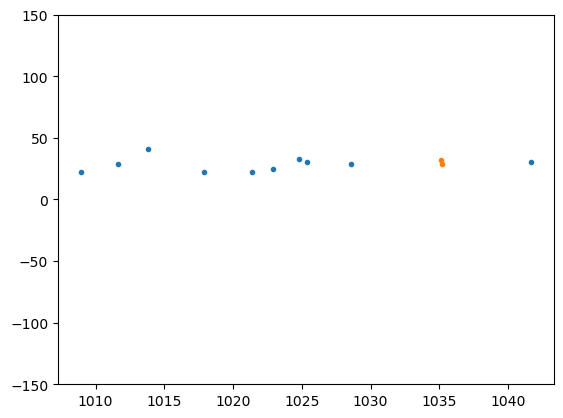

In [12]:
ictal=True # True for ictal, False for control network
spread=False # True for spread (i.e. low spatial information), False for non-spread
wh=4 # which network to simulate, there are 0-9 tota networks which are statistically the same, just trained on different seeds

# runs the simulation
center = 30
s_times,s_senders,s_place_CA1,s_place_CA3,CA3_lfp_sig,CA1_lfp_sig,lfp_sig_ts,pf_CA3,pf_CA1 = sim_wrapper(data,
                                                                                                         wh,ictal,1500,[center-10,center+10],
                                                                                                         1000,spread=spread,cue_weight=80,bg_w=10,seed=1111)
plt.close('all')
plt.figure()
plt.plot(s_times,s_place_CA3,'.')
plt.plot(s_times,s_place_CA1,'.')
plt.ylim([-150,150])
plt.show()

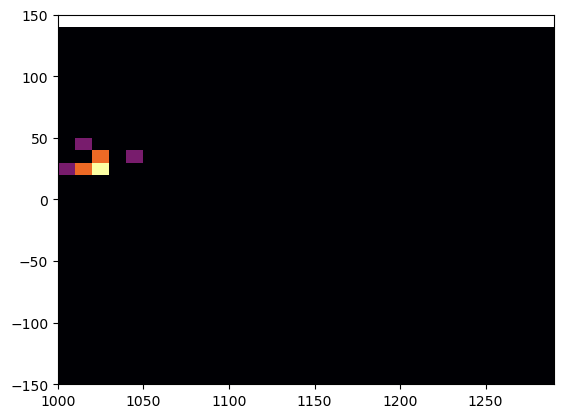

In [13]:
plt.close('all')
plt.figure()
plt.hist2d(s_times,s_place_CA3,bins=[np.arange(1000,1300,10),np.arange(-150,150,10)],cmap='inferno')
plt.ylim([-150,150])
#plt.show()
plt.savefig('Figure8B_lowcontaim_highinfo.svg')

## Reproduces Figure 8C

In [16]:
def compute_cue_spread(ictal_state,spread,cue_location,cue_weight,wh,seed=1234):
    # cue the network at the cue_location
    s_times,_,_,s_place_CA3,_,_,_,_,_ = sim_wrapper(data,wh,ictal_state,450,cue_location,100,spread=spread,cue_weight=cue_weight,bg_w=10,seed=seed)
    # count the number of spikes that overlap with each readout zone after the cue
    spike_counts_contaimination = np.sum((s_times > 100) & ((s_place_CA3 < cue_location[0]) | (s_place_CA3 > cue_location[1])))
    spike_prop_contaimination = spike_counts_contaimination/np.sum((s_times > 100) & ((s_place_CA3 > cue_location[0]) & (s_place_CA3 < cue_location[1])))
    return spike_counts_contaimination,spike_prop_contaimination, np.sum((s_times > 100) & ((s_place_CA3 < 0)))

In [17]:
pos = np.arange(10,100,20)
cue_locations = [[x-10,x+10] for x in pos]
N_replicas = 10 # but fixing the network though to compare the effect of the cue without confounders like network variability
wh = 10

# spike_counts_contaimination_low_entropy = np.zeros((len(cue_locations),len(cue_weights),10))
# spike_counts_contaimination_high_entropy = np.zeros((len(cue_locations),len(cue_weights),10))

spike_counts_contaimination_low_entropy = np.zeros((len(cue_locations),wh,N_replicas))
spike_counts_contaimination_high_entropy = np.zeros((len(cue_locations),wh,N_replicas))
spike_counts_control = np.zeros((len(cue_locations),wh,N_replicas))

spike_counts_contaimination_low_entropy_crossover = np.zeros((len(cue_locations),wh,N_replicas))
spike_counts_contaimination_high_entropy_crossover = np.zeros((len(cue_locations),wh,N_replicas))
spike_counts_control_crossover = np.zeros((len(cue_locations),wh,N_replicas))

# repeat for each replica serially
for i in range(len(cue_locations)):
    for j in range(wh):
        for k in range(N_replicas):
            spike_counts_contaimination_low_entropy[i,j,k],_,spike_counts_contaimination_low_entropy_crossover[i,j,k] = compute_cue_spread(True,False,cue_locations[i],80,j,k+1)
            spike_counts_contaimination_high_entropy[i,j,k],_,spike_counts_contaimination_high_entropy_crossover[i,j,k] = compute_cue_spread(True,True,cue_locations[i],80,j,k+1)
            spike_counts_control[i,j,k],_,spike_counts_control_crossover[i,j,k] = compute_cue_spread(False,False,cue_locations[i],80,j,k+1)


Aug 01 14:36:22 NodeManager::prepare_nodes [Info]: 
    Preparing 3080 nodes for simulation.

Aug 01 14:36:22 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3080
    Simulation time (ms): 450
    Number of OpenMP threads: 16
    Not using MPI

Aug 01 14:36:23 SimulationManager::run [Info]: 
    Simulation finished.

Aug 01 14:36:24 NodeManager::prepare_nodes [Info]: 
    Preparing 3080 nodes for simulation.

Aug 01 14:36:24 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3080
    Simulation time (ms): 450
    Number of OpenMP threads: 16
    Not using MPI

Aug 01 14:36:25 SimulationManager::run [Info]: 
    Simulation finished.

Aug 01 14:36:26 NodeManager::prepare_nodes [Info]: 
    Preparing 3080 nodes for simulation.

Aug 01 14:36:26 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3080
    Simulation time (ms): 450
    Number of OpenMP threads: 16
    Not using MPI

Aug 01 14:36:26 SimulationManager::run [Info]: 

In [18]:
# save the results
np.savez_compressed('data/cue_spread_with_controls_compressed_73025_20steps_10net_10replica_t300_1p0_STIMPLACE.npz',
         spike_counts_contaimination_low_entropy=spike_counts_contaimination_low_entropy_crossover,
         spike_counts_contaimination_high_entropy=spike_counts_contaimination_high_entropy_crossover,
         spike_counts_control=spike_counts_control_crossover,
         wh_used=wh,pos=pos,cue_locations=cue_locations,cue_weights=80)

In [1]:
# load the results
import numpy as np
from scipy import interpolate, signal
import matplotlib.pyplot as plt

N_replicas = 10
data = np.load('data/cue_spread_with_controls_compressed_73025_20steps_10net_10replica_t300_1p0_STIMPLACE.npz',allow_pickle=True)
spike_counts_contaimination_low_entropy = data['spike_counts_contaimination_low_entropy']
spike_counts_contaimination_high_entropy = data['spike_counts_contaimination_high_entropy']
spike_counts_control = data['spike_counts_control']
wh = data['wh_used']
pos = data['pos']
cue_locations = data['cue_locations']

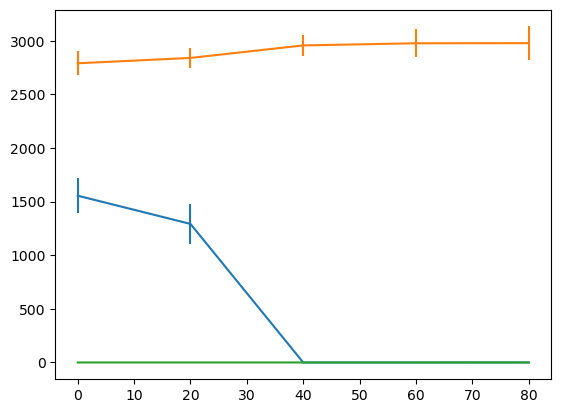

In [13]:
plt.close('all')
plt.figure()
ax = plt.subplot(111)
ax.errorbar(90-pos,spike_counts_contaimination_low_entropy.mean(axis=(1,2)).flatten()+1e-1, # low entropy = high spatial information
            yerr=spike_counts_contaimination_low_entropy.std(axis=(1,2)).flatten()/np.sqrt(N_replicas+wh-1))
ax.errorbar(90-pos,spike_counts_contaimination_high_entropy.mean(axis=(1,2)).flatten()+1e-1,
                         yerr=spike_counts_contaimination_high_entropy.std(axis=(1,2)).flatten()/np.sqrt(N_replicas+wh-1))
ax.errorbar(90-pos,spike_counts_control.mean(axis=(1,2)).flatten()+1e-1,
            yerr=spike_counts_control.std(axis=(1,2)).flatten()/np.sqrt(N_replicas+wh-1))
#ax.set_yscale('log')
#plt.savefig('figure8C.svg')
plt.show()

## Shows different networks which were trained independently have similar behavior

These figures show the contribution of each network replica and each seed to the "error bars" 

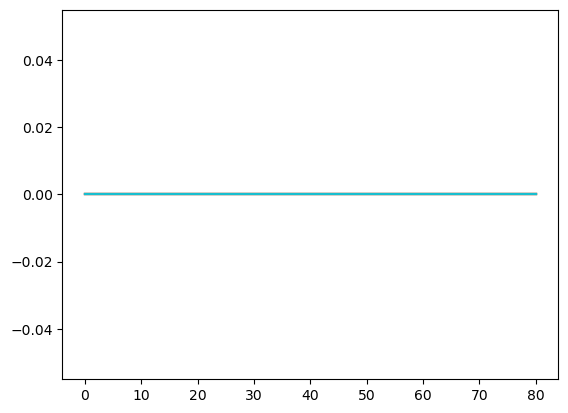

In [12]:
plt.figure()
plt.plot(90-pos,spike_counts_control[:,9,:])
#plt.ylim(0,2000)
plt.show()

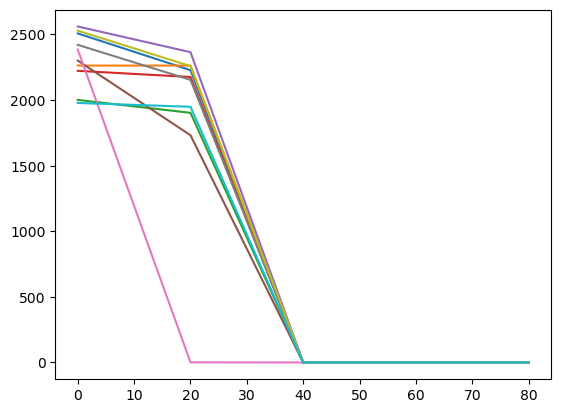

In [3]:
plt.figure()
plt.plot(90-pos,spike_counts_contaimination_low_entropy[:,9,:])
#plt.ylim(0,2000)
plt.show()

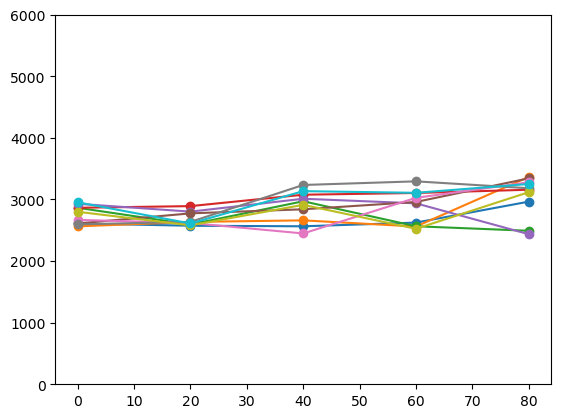

In [4]:
plt.figure()
plt.plot(90-pos,spike_counts_contaimination_high_entropy[:,9,:]+np.random.rand(N_replicas)*20,'-o')
plt.ylim(0,6000)
plt.show()